This notebook tests the idea of a Gaussian copula, particularly focusing on how this could be implemented for a situation where IID samples from a unit-hypercube are provided by a black-box algorithm and we wish to set correlations between different dimensions. 

Let's start by importing a few things:

In [3]:
%matplotlib inline

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.ion()
import numpy as np

"Freeze" a uniform distribution between 0 and 1, and a standard Gaussian:

In [ ]:
norm = stats.distributions.norm(0,1)
uniform = stats.uniform(0,1)

Set number of dimensions and number of samples. Only the first 2 dimensions will be visualized later, so setting ndims=2 is enough. Using more than 10k samples might be a little slow.

In [11]:
##### number of sampling dimensions and samples
ndims=2
nsamples = 10000

The most common use case of Gaussian copulas would use a provided correlation matrix among parameters and sample from a multidimensional Gaussian producing correlated samples whose marginal distribution is uniform. Let's say our correlation matrix is simply tri-diagonal:

In [8]:
##### define correlation matrix
def tridiag(a,b,c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

a = [0.5,]* (ndims-1)
b = [1.0,]* ndims
c = [0.5,]* (ndims-1)
Sigma = tridiag(a,b,c)

 We can then create a multi-dimensional (here, ndims=2) correlated Gaussian and plot it:

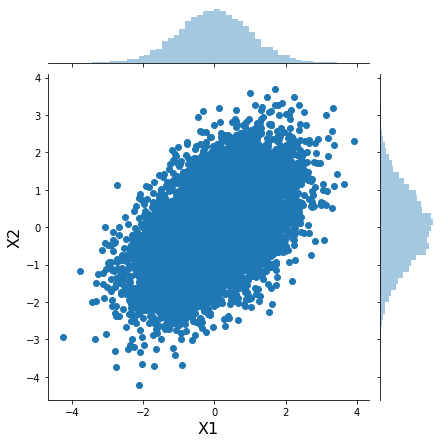

In [12]:
mvnorm = stats.multivariate_normal(mean=[0, 0], cov=Sigma)

# Generate random samples from multivariate normal 
x = mvnorm.rvs(nsamples)              

h = sns.jointplot(x[:, 0], x[:, 1], stat_func=None);  #kind='kde'
h.set_axis_labels('X1', 'X2', fontsize=16);

The simplest way to visualize a Gaussian copula is to use these samples (directly obtained from the multi-dimensional correlated Gaussian) and use the property that the CDF of each variable has a uniform distribution:

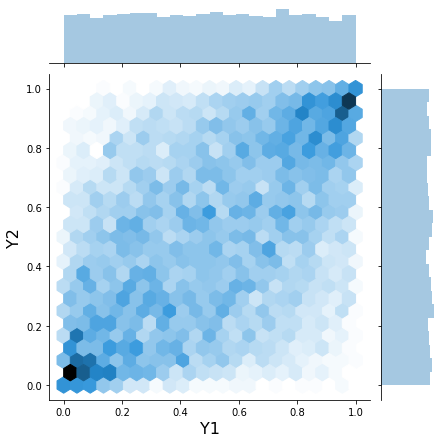

In [13]:
x_unif = norm.cdf(x)
h = sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)
h.set_axis_labels('Y1', 'Y2', fontsize=16);


The 2-dimensional plot above is the standard way to show the "uniformity" of marginals from a copula. 

Now, let's say that our problem is a little different: we are *given* uniform IID samples (e.g. from a black-box algorithm) and we want to correlate them (still having uniform marginals). The following procedures shows how to do this:

In [15]:
##### pre-allocate some arrays
xs = np.zeros((nsamples, ndims))
zs = np.zeros_like(xs)
ws_csky = np.zeros_like(xs)
ws_eig = np.zeros_like(xs)
us_csky = np.zeros_like(xs)
us_eig = np.zeros_like(xs)

for sam in np.arange(nsamples):
    ### (1) sample uniform, multidimensional: u_i ~ U(0,1) 
    # this is simulating what our external "black-box" algorithm would give
    xs[sam, :] = [uniform.rvs(1) for dim in np.arange(ndims)]
    
    ##### (2) transform to gaussian, z_i ~ N(0,1)
    zs[sam,:] = [norm.ppf(xx) for xx in xs[sam, :]]
    
    ##### (3) correlate gaussians: w_i =\Sigma^{1/2} z_i    

    ### Cholesky decomposition
    Sig_csky = np.linalg.cholesky(Sigma)
    Sigma_csky = np.dot(Sig_csky, Sig_csky.T.conj())
    assert np.allclose(Sigma_csky, Sigma)
    ws_csky[sam,:] = Sig_csky.dot(zs[sam,:])
    
    ### eigen decomposition
    ww, vv = np.linalg.eig(Sigma)
    Sigma_rec = vv.dot(np.diag(ww).dot(np.linalg.inv(vv)))
    assert np.allclose(Sigma_rec, Sigma)
    ws_eig[sam,:] = vv.dot(np.diag(ww)**0.5).dot(zs[sam,:])
    
    ##### (4) correlated uniform: \tilde{u}_i = \Phi(w_i) (Gaussian CDF)
    us_csky[sam,:] = [norm.cdf(val) for val in ws_csky[sam,:]]
    us_eig[sam,:] = [norm.cdf(val) for val in ws_eig[sam,:]]
    

Here, we first creatd a vector of uniform IID samples, which in our scenario would actually be done by our black-box algorithm (here substituted with pseudo-random samples from scipy). 

In the loop above, we took these uniform samples, mapped them to a uncorrelated Gaussians in each dimension (via the PPF = inverse CDF function). We then decomposed the correlation matrix created above in 2 different ways: via a Cholesky decomposition ($\Sigma = \Sigma^{1/2} \Sigma^{1/2*}$) and via an eigen-decomposition ($\Sigma = U \Lambda U$). These are different operations, but are shown here to give the same results! For either decomposition, the "assert" statements show that indeed the scipy decompositions recover the full correlation matrix as by their formal definition. 

Now, taking the "ws" vectors for each sample (first for the Cholesky, then for their eigen-decomposition), we multiply $\Sigma^{1/2}$ by the Gaussian uncorrelated samples above. This produces correlated Gaussians. 

As a final step, we take correlated samples from Gaussian distributed variables and map them to correlated uniformly-distruted variables. 

Let's see what are the results. First, check the correlation between different dimensions of the initial IID uniformly-distributed samples (there should be none!):

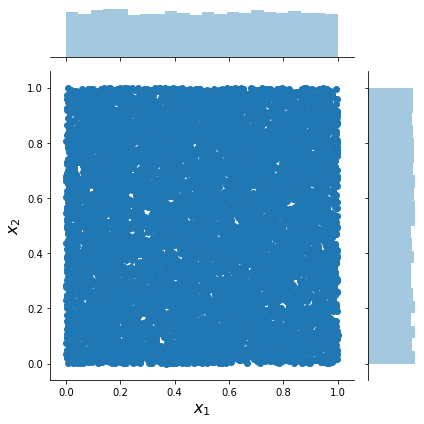

In [16]:
##### check correlation between uniform distribution dimensions (there should be none)
h = sns.jointplot(xs[:, 0], xs[:, 1], stat_func=None) #kind='kde', stat_func=None);
h.set_axis_labels(r'$x_1$', r'$x_2$', fontsize=16);plt.tight_layout()

Nice! Clearly uniform and uncorrelated distributions. 

Next, let's check the Gaussian (still IID) samples that were obtained via the Gaussian PPF, using the uniform IID samples above:

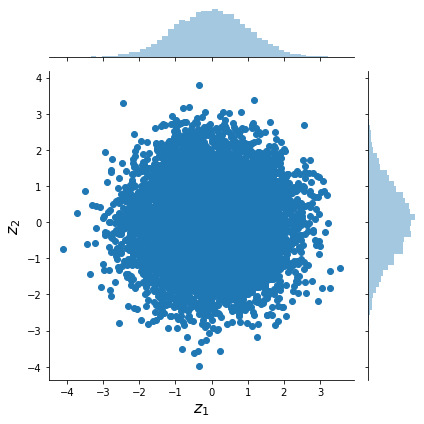

In [17]:
##### check gaussianity and correlations of step (2) (there should be none, again)
h = sns.jointplot(zs[:, 0], zs[:, 1], stat_func=None) #kind='kde', stat_func=None);
h.set_axis_labels(r'$z_1$', r'$z_2$', fontsize=16);plt.tight_layout()

Clearly, these Gaussian samples are also uncorrelated, as expected. Now, let's plot the results of the Cholesky and eigen-decompositions. We expect these to be correlated, since we obtained them with the correlation matrix that we set at the beginning. And indeed...

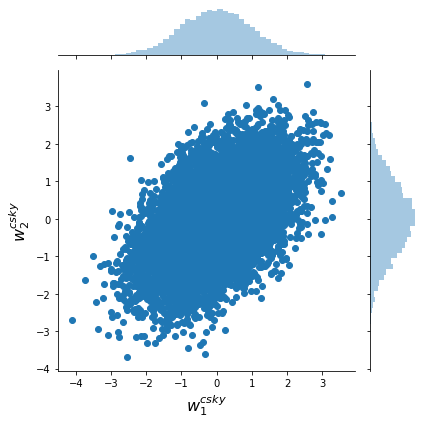

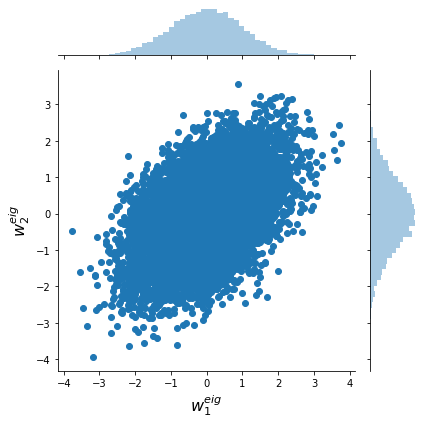

In [18]:
##### correlated gaussianity of step (3)
h = sns.jointplot(ws_csky[:, 0], ws_csky[:, 1], stat_func=None) #kind='kde', stat_func=None);
h.set_axis_labels(r'$w_1^{csky}$', r'$w_2^{csky}$', fontsize=16);plt.tight_layout()

h = sns.jointplot(ws_eig[:, 0], ws_eig[:, 1], stat_func=None) #kind='kde', stat_func=None);
h.set_axis_labels(r'$w_1^{eig}$', r'$w_2^{eig}$', fontsize=16);plt.tight_layout()

Interestingly, while the Cholesky and the eigen-decompositions give different matrices for $\Sigma^{1/2}$, the distributions that result from their application look the same! So, it doesn't matter which one we use. 

It's useful to check which decomposition is actually faster in Python:

In [19]:
%timeit Sig_csky = np.linalg.cholesky(Sigma)

The slowest run took 14.67 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.38 µs per loop


In [20]:
%timeit ww, vv = np.linalg.eig(Sigma)

The slowest run took 51.61 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 34.4 µs per loop


So we see that the Cholesky decomposition is more than 4 times faster! 

Finally, let's look at whether we managed to produce correlated uniform marginal distributions along each dimension:

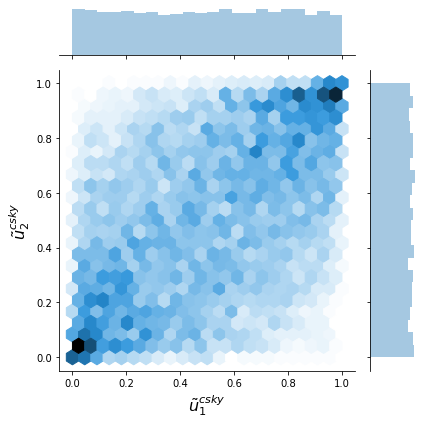

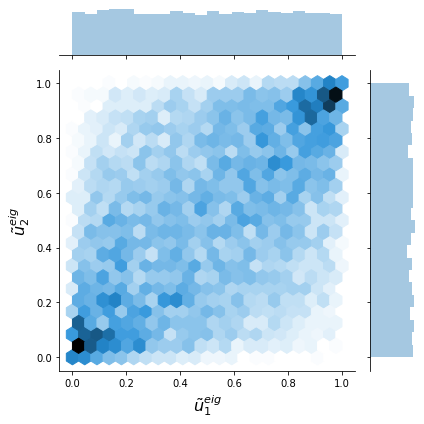

In [23]:
##### correlated uniform -- step (4)
h = sns.jointplot(us_eig[:, 0], us_eig[:, 1], stat_func=None, kind='hex') #kind='kde', stat_func=None);
h.set_axis_labels(r'$\tilde{u}_1^{csky}$', r'$\tilde{u}_2^{csky}$', fontsize=16);plt.tight_layout()

h = sns.jointplot(us_csky[:, 0], us_csky[:, 1], stat_func=None, kind='hex') #kind='kde', stat_func=None);
h.set_axis_labels(r'$\tilde{u}_1^{eig}$', r'$\tilde{u}_2^{eig}$', fontsize=16);plt.tight_layout()

Now compare these last two plots (obtained via the two different decompositions, but giving the same distributions) with the initial result obtained by directly sampling from the multi-dimensional correlated Gaussian. They look the same! 

Et voilà, success! 